In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data

# Fetching Data

In [3]:
def fetch_historical_data(symbols, start_date, end_date):
    df_prices = data.DataReader(symbols, start=start_date, end=end_date, data_source='yahoo')
    df_prices = df_prices[['Adj Close']]
    df_prices.columns = [' '.join(col).strip() for col in df_prices.columns.values]
    return df_prices

## From `usage.ipynb`

In [4]:
import os
from import_stocks import read_stock_symbols
from yahoo_data_provider import get_yahoo_data

# Define the base path relative to the current working directory
base_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'assets'))
stocks_symbol_list_path = os.path.join(base_path, 'nasdaq_100_stocks.csv')

stocks = read_stock_symbols(stocks_symbol_list_path, num_symbols=5)
start_date=(2018, 1, 1)
end_date=(2020, 1, 30)

data, tickers, mu, sigma = get_yahoo_data(stocks, start_date, end_date)

print("Stocks: ", stocks)
print("Mean return: ", mu)
print("Covariance: ", sigma)

Stocks:  ['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'AMZN']
Mean return:  [0.001422   0.00146497 0.00073748 0.00071872 0.00103379]
Covariance:  [[0.00029801 0.0001761  0.00017784 0.00017514 0.00020138]
 [0.0001761  0.00023284 0.00018618 0.00018558 0.00021579]
 [0.00017784 0.00018618 0.00026758 0.00026468 0.00021273]
 [0.00017514 0.00018558 0.00026468 0.00026435 0.00021087]
 [0.00020138 0.00021579 0.00021273 0.00021087 0.00035352]]


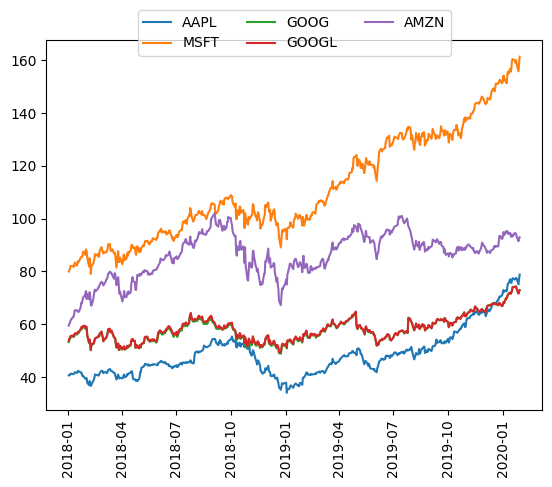

In [6]:
from visualizer import print_result, display_stocks_graph
display_stocks_graph(data)

In [7]:
from portfolio import define_portfolio_optimization_problem

q = 0.5  # set risk factor
budget = 3  # set budget

portfolio, portfolio_quadratic_program = define_portfolio_optimization_problem(expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget)
print("Portfolio Quadratic Program: ", portfolio_quadratic_program)

Portfolio Quadratic Program:  minimize 0.00014900706081021748*x_0^2 + 0.00017609807223463252*x_0*x_1 + 0.00017783574735122666*x_0*x_2 + 0.0001751420770671717*x_0*x_3 + 0.0002013829657755957*x_0*x_4 + 0.00011642069641118648*x_1^2 + 0.0001861771705531581*x_1*x_2 + 0.00018557750729848987*x_1*x_3 + 0.00021578957903556638*x_1*x_4 + 0.00013378759479955768*x_2^2 + 0.00026468450621626254*x_2*x_3 + 0.00021273034648573833*x_2*x_4 + 0.00013217359804846516*x_3^2 + 0.00021086670484482726*x_3*x_4 + 0.0001767586506029921*x_4^2 - 0.0014220041939711622*x_0 - 0.0014649673522708524*x_1 - 0.0007374813814049051*x_2 - 0.0007187150833367909*x_3 - 0.0010337875655491845*x_4 (5 variables, 1 constraints, 'Portfolio optimization')


In [10]:
from solver import solve_using_sampling_vqe
from get_optimal_stocks import get_optimal_stocks

num_stocks = len(stocks)
result = solve_using_sampling_vqe(portfolio_quadratic_program, num_stocks)

# print_result(stocks, portfolio, result)

In [11]:
optimal_stocks = get_optimal_stocks(stocks, result)
print("Optimal Stocks: ", optimal_stocks)

Optimal Stocks:  ['AAPL', 'MSFT', 'AMZN']


In [12]:
df_prices = fetch_historical_data(optimal_stocks, start_date, end_date)
print("Historical Data: ", df_prices)

AttributeError: 'YahooDataProvider' object has no attribute 'DataReader'

# Calculating Metrices

In [ ]:
def calculate_portfolio_weights(symbols, portfolio_value, price_at_end_date):
    portfolio_weights_random = np.random.dirichlet(np.ones(len(symbols)), size=1)[0]
    no_of_shares = [round((x * portfolio_value) / price, 5) for x,
    price in zip(portfolio_weights_random, price_at_end_date)]
    return portfolio_weights_random, no_of_shares

def calculate_metrics(df_returns, df_mean_stdev, risk_free_rate):
    mu = np.array(df_mean_stdev["Mean Log Daily Return"].values.tolist())
    sigma = np.array(df_mean_stdev["StdDev Log Daily Return"].values.tolist())

    iteration_std_dev = df_mean_stdev.tail(1).values[0][2]
    iteration_mean = df_mean_stdev.tail(1).values[0][1]

    negative_returns_only = df_returns[df_returns['Log Daily Returns Adj Close Portfolio'] < 0]
    iteration_negative_returns_std_dev = negative_returns_only['Log Daily Returns Adj Close Portfolio'].std()

    iteration_sharpe_ratio = round(((np.exp(iteration_mean) - 1) - risk_free_rate) / (np.exp(iteration_std_dev) - 1), 3)
    iteration_sortino_ratio = round(((np.exp(iteration_mean) - 1) - risk_free_rate) / (np.exp(iteration_negative_returns_std_dev) - 1), 3)

    return iteration_sharpe_ratio, iteration_sortino_ratio, iteration_std_dev, iteration_mean


# Monte Carlo Simulations

In [ ]:
def efficient_portfolio_historical(start_date, end_date, symbols, portfolio_value, no_of_iterations_mc, annual_risk_free_rate, image_counter, target_folder):
    risk_free_rate = (1 + annual_risk_free_rate) ** (1/252) - 1
    
    df_prices = fetch_historical_data(start_date, end_date, symbols)
    price_at_end_date = [df_prices[[f'Adj Close {symbol}']][-1:].values[0][0] for symbol in symbols]
    
    results_table = []

    for _ in range(no_of_iterations_mc):
        portfolio_weights_random, no_of_shares = calculate_portfolio_weights(symbols, portfolio_value, price_at_end_date)

        df_prices_inner = df_prices.copy()
        df_prices_inner["Adj Close Portfolio"] = df_prices_inner.mul(no_of_shares).sum(1)

        df_returns, df_mean_stdev = calc_returns(df_prices_inner, symbols)

        iteration_sharpe_ratio, iteration_sortino_ratio, iteration_std_dev, iteration_mean = calculate_metrics(df_returns, df_mean_stdev, risk_free_rate)

        results_table.append([portfolio_weights_random, iteration_std_dev, iteration_mean, iteration_sharpe_ratio, iteration_sortino_ratio])

        df_prices_inner.drop('Adj Close Portfolio', inplace=True, axis=1)

    final_results_table = pd.DataFrame(results_table, columns=["Weights", "Std Dev", "Mean", "Sharpe Ratio", "Sortino Ratio"])

    historical_df_returns, historical_df_mean_stdev = calc_returns(df_prices, symbols)
    historical_df_mean_stdev = historical_df_mean_stdev[['Stock', 'StdDev Log Daily Return', 'Mean Log Daily Return']]
    historical_df_mean_stdev.columns = ['Stock', 'Std Dev', 'Mean']

    fig, ax = plt.subplots(figsize=(10, 5))
    final_results_table.plot.scatter(x="Std Dev", y='Mean', ax=ax)
    historical_df_mean_stdev.plot.scatter(x="Std Dev", y='Mean', c='r', marker='x', ax=ax)

    sharpe_std_dev = final_results_table.nlargest(1, ['Sharpe Ratio'])['Std Dev'].values[0]
    sharpe_mean = final_results_table.nlargest(1, ['Sharpe Ratio'])['Mean'].values[0]
    sharperounded_weights = [round(num, 4) for num in final_results_table.nlargest(1, ['Sharpe Ratio'])['Weights'].values[0]]
    sharpeweight_string = [[symbol, weight] for symbol, weight in zip(symbols, sharperounded_weights)]
    sharpe_label = "Optimal Sharpe Ratio"
    sharpe_detail = f'Optimal Sharpe Ratio: {final_results_table.nlargest(1, ["Sharpe Ratio"])["Sharpe Ratio"].values[0]} with Weights {sharpeweight_string}'

    sortino_std_dev = final_results_table.nlargest(1, ['Sortino Ratio'])['Std Dev'].values[0]
    sortino_mean = final_results_table.nlargest(1, ['Sortino Ratio'])['Mean'].values[0]
    sortinorounded_weights = [round(num, 4) for num in final_results_table.nlargest(1, ['Sortino Ratio'])['Weights'].values[0]]
    sortinoweight_string = [[symbol, weight] for symbol, weight in zip(symbols, sortinorounded_weights)]
    sortino_label = 'Optimal Sortino Ratio'
    sortino_detail = f'Optimal Sortino Ratio: {final_results_table.nlargest(1, ["Sortino Ratio"])["Sortino Ratio"].values[0]} with Weights {sortinoweight_string}'

    sharpe_sortino = pd.DataFrame(zip([sharpe_std_dev, sortino_std_dev], [sharpe_mean, sortino_mean]), index=['Optimal Sharpe', 'Optimal Sortino'], columns=['Std Dev', 'Mean'])
    sharpe_sortino.plot.scatter(x="Std Dev", y='Mean', c='g', marker='x', ax=ax)

    txt = list(historical_df_mean_stdev['Stock']) + [sharpe_label, sortino_label]
    z = list(historical_df_mean_stdev['Std Dev']) + [sharpe_std_dev, sortino_std_dev]
    y = list(historical_df_mean_stdev['Mean']) + [sharpe_mean, sortino_mean]
    for i, text in enumerate(txt):
        ax.annotate(text, (z[i], y[i]))

    plt.title(f"Mean vs Std Dev Of Log Returns For {no_of_iterations_mc} Different Portfolio Weights")
    plt.savefig(f'static/{target_folder}/{image_counter}_efficientportfolio.png')
    print(sharpe_detail)
    print(sortino_detail)

    final_results_table['Log Returns Std Dev'] = final_results_table['Std Dev']
    final_results_table['Log Returns Mean'] = final_results_table['Mean']
    final_results_table = final_results_table[['Weights', 'Log Returns Std Dev', 'Log Returns Mean', 'Sharpe Ratio', 'Sortino Ratio']]

    return final_results

##  EXPERIMENTAL AREA

In [13]:
def EfficientPortfolioHistorical(start_date,end_date,symbols,portfolioValue,NoOfIterationsMC,AnnualRiskFreeRate,imagecounter,targetfolder):
    
    RiskFreeRate=(1+AnnualRiskFreeRate)**(1/252)-1
    #Effective rate for period = (1 + annual rate)**(1 / # of periods) – 1
    
    for symbol in symbols:
        dfprices = data.DataReader(symbols, start=start_date, end=end_date, data_source='yahoo')
        dfprices = dfprices[['Adj Close']]
    dfprices.columns=[' '.join(col).strip() for col in dfprices.columns.values]
    
    priceAtEndDate=[]
    for symbol in symbols:
        priceAtEndDate.append(dfprices[[f'Adj Close {symbol}']][-(1):].values[0][0])
    
    symbolsWPortfolio=symbols+["Portfolio"]
    
    ResultsTable=[]
    
    for i in range(0,NoOfIterationsMC):
        
        dfprices_inner=dfprices
        portfolioWeightsRandom=list(np.random.dirichlet(np.ones(len(symbols)),size=1)[0])
        
        noOfShares=[]
        portfolioValPerSymbol=[x * portfolioValue for x in portfolioWeightsRandom]
        for j in range(0,len(symbols)):
            noOfShares.append(portfolioValPerSymbol[j]/priceAtEndDate[j])
        noOfShares=[round(element, 5) for element in noOfShares]
        listOfColumns=dfprices_inner.columns.tolist()   
        dfprices_inner["Adj Close Portfolio"]=dfprices_inner[listOfColumns].mul(noOfShares).sum(1)
        dfreturns ,df_mean_stdev=calc_returns(dfprices_inner,symbols)
        
        mu=np.array(df_mean_stdev["Mean Log Daily Return"].values.tolist())
        sigma=np.array(df_mean_stdev["StdDev Log Daily Return"].values.tolist())
             
        IterationStdDev=df_mean_stdev.tail(1).values[0][2]
        IterationMean=df_mean_stdev.tail(1).values[0][1]
            
        negativereturnsonly=pd.DataFrame(dfreturns.iloc[:,len(dfreturns.columns)-1])
        negativereturnsonly=negativereturnsonly[negativereturnsonly['Log Daily Returns Adj Close Portfolio']<0]
        IterationNegativeReturnsStdDev=negativereturnsonly['Log Daily Returns Adj Close Portfolio'].std()
        
        # Note to go from LOG returns to Simple returns , I used simple returns =exp(log returns)−1 
        IterationSharpeRatio=round(((np.exp(IterationMean)-1)-RiskFreeRate)/(np.exp(IterationStdDev)-1),3)
        
        IterationSortinoRatio=round(((np.exp(IterationMean)-1)-RiskFreeRate)/(np.exp(IterationNegativeReturnsStdDev)-1),3)
        
        X=[portfolioWeightsRandom,IterationStdDev,IterationMean,IterationSharpeRatio,IterationSortinoRatio]
        
        ResultsTable.append(X)
        
        dfprices_inner.drop('Adj Close Portfolio',inplace=True, axis=1)
    
    FinalResultsTable=pd.DataFrame(ResultsTable,columns=["Weights","Std Dev","Mean","Sharpe Ratio","Sortino Ratio"])
    
    historical_dfreturns ,historical_df_mean_stdev=calc_returns(dfprices,symbols)
    
    historical_df_mean_stdev=historical_df_mean_stdev[['Stock','StdDev Log Daily Return','Mean Log Daily Return']]
    historical_df_mean_stdev.columns=['Stock','Std Dev','Mean']
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    FinalResultsTable.plot.scatter(x="Std Dev",y='Mean',ax=ax)
    historical_df_mean_stdev.plot.scatter(x="Std Dev",y='Mean',c='r',marker='x',ax=ax)
    SharpeStdDev=FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Std Dev'].values[0]
    SharpeMean=FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Mean'].values[0]
    Sharperoundedweights=[round(num, 4) for num in FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Weights'].values[0]]
    Sharpeweightstring=[]
    for i in range(0,len(symbols)):
        Sharpeweightstring.append([symbols[i]+":",Sharperoundedweights[i]])
    SharpeLabel="Optimal Sharpe Ratio"
    SharpeDetail='Optimal Sharpe Ratio: '+str(FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Sharpe Ratio'].values[0])+" with Weights "+str(Sharpeweightstring)
    SortinoStdDev=FinalResultsTable.nlargest(1,['Sortino Ratio'])['Std Dev'].values[0]
    SortinoMean=FinalResultsTable.nlargest(1,['Sortino Ratio'])['Mean'].values[0]
    Sortinoroundedweights=[round(num, 4) for num in FinalResultsTable.nlargest(1,['Sortino Ratio'])['Weights'].values[0]]
    Sortinoweightstring=[]
    for i in range(0,len(symbols)):
        Sortinoweightstring.append([symbols[i]+":",Sortinoroundedweights[i]])
    SortinoLabel='Optimal Sortino Ratio'
    SortinoDetail='Optimal Sortino Ratio: '+str(FinalResultsTable.nlargest(1,['Sortino Ratio'])['Sortino Ratio'].values[0])+" with Weights "+str(Sortinoweightstring)
    
    SharpeSortino=pd.DataFrame(zip([SharpeStdDev,SortinoStdDev],[SharpeMean,SortinoMean]),index=['Optimal Sharpe','Optimal Sortino'],columns=['Std Dev','Mean'])
    SharpeSortino.plot.scatter(x="Std Dev",y='Mean',c='g',marker='x',ax=ax)
    
    txt=list(historical_df_mean_stdev['Stock'])+[SharpeLabel,SortinoLabel]
    z=list(historical_df_mean_stdev['Std Dev'])+[SharpeStdDev,SortinoStdDev]
    y=list(historical_df_mean_stdev['Mean'])+[SharpeMean,SortinoMean]
    for i, text in enumerate(txt):
            ax.annotate(text, (z[i], y[i]))
    
    plt.title("Mean vs Std Dev Of Log Returns For "+str(NoOfIterationsMC)+" Different Portfolio Weights")
    plt.savefig(f'static/{targetfolder}/{imagecounter}_efficientportfolio.png')
    print(SharpeDetail)
    print(SortinoDetail)
    
    FinalResultsTable['Log Returns Std Dev']=FinalResultsTable['Std Dev']
    FinalResultsTable['Log Returns Mean']=FinalResultsTable['Mean']
    FinalResultsTable=FinalResultsTable[['Weights','Log Returns Std Dev','Log Returns Mean','Sharpe Ratio','Sortino Ratio']]
    
    return FinalResultsTable, SharpeDetail, SortinoDetail